In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


In [3]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# ***Exploratory data analysis***

In [6]:
def plot_missing_data(dataset, title):          #function to plot heatmap of missing data of a dataset
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(title)  
    sns.heatmap(dataset.isnull(), cbar=False)

In [7]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


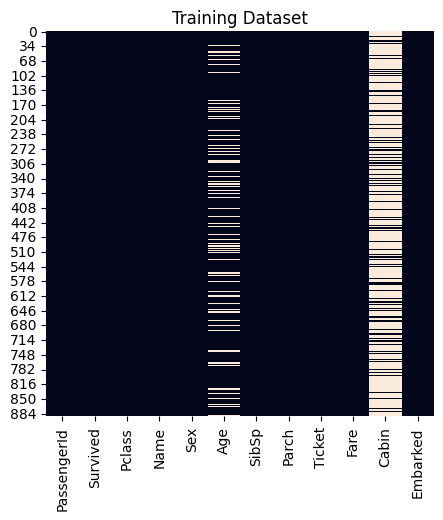

In [8]:
plot_missing_data(train_df, "Training Dataset")

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


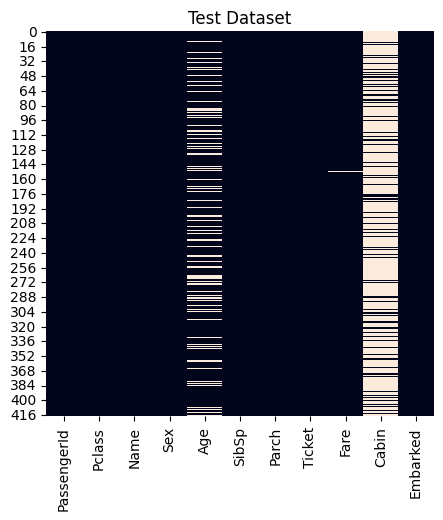

In [10]:
plot_missing_data(test_df, "Test Dataset")

A naive approach to solve this problem would be to remove the feature completely from the dataset. However, since we do not know how much information these they provide they further investigation is needed. Maybe we find that it would make sense to impute the missing values using sophisticated data imputation methods.

It is essential to explore which features should be considered and which should not.

I would argue that most important skill of a Machine Learning Engineer/Data Scientist is to be unbiased, not assume things and to ask good questions.


> ***Question 1: How many passengers survived?***

In [11]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [12]:
train_df['Survived'].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [13]:
def bar_chart_stacked(dataset, feature, stacked = True):               #Function that plots a bar chart of survived and died based on feature provided
    survived = dataset[dataset['Survived']==1][feature].value_counts()
    dead = dataset[dataset['Survived']==0][feature].value_counts()
    df_survived_dead = pd.DataFrame([survived,dead])
    df_survived_dead.index = ['Passengers Survived','Passengers Died']
    ax = df_survived_dead.plot(kind='bar',stacked=stacked, figsize=(5,5))

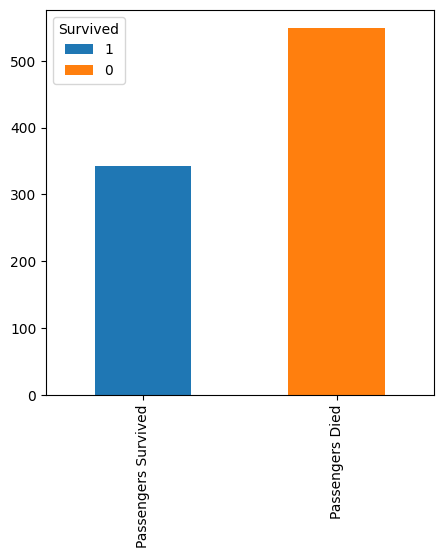

In [14]:
bar_chart_stacked(train_df, "Survived")

> ***Question 2: Is the likelihood of survival dependent on gender?***

In [15]:
train_df['Sex'].value_counts().to_frame()


,count
Sex,
male,577
female,314


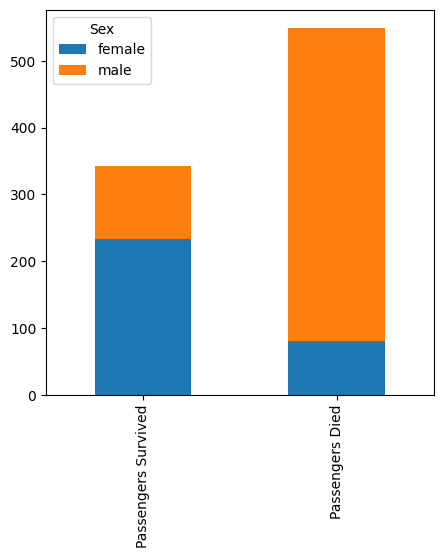

In [16]:
bar_chart_stacked(train_df, "Sex")


In [17]:
train_df.groupby('Sex').Survived.mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

> ***Question 3: Could it be that the class to which a passenger belonged correlates with the probability of survival??***

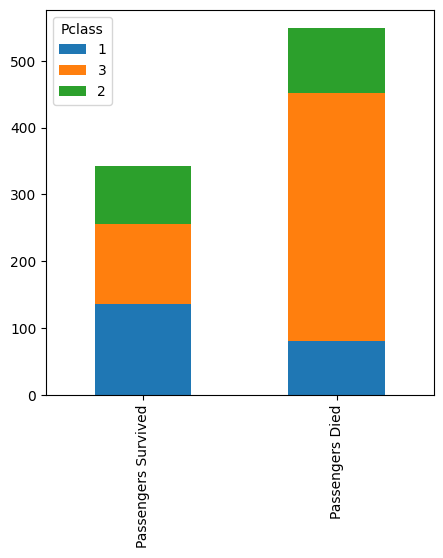

In [18]:
bar_chart_stacked(train_df, 'Pclass')

In [19]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count')


Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [20]:
train_df.groupby(['Pclass']).Survived.mean().to_frame()


,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


> ***Question 4: Is the higher survival rate in Class 1 due to the class itself or due to a skewed gender distribution in which female passengers dominate?***

In [21]:
def bar_chart_compare(dataset, feature1, feature2=None, title = "Survival rate by sex and class'"):
    plt.figure(figsize = [5,5])
    plt.title(title)
    g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')

/tmp/ipykernel_20/2402733668.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')


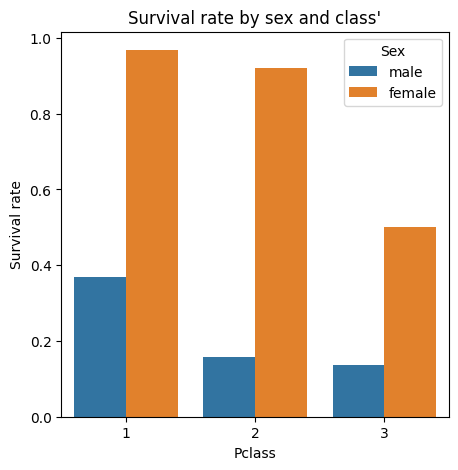

In [22]:
bar_chart_compare(train_df, "Pclass", "Sex")


In [23]:
pd.pivot_table(train_df, index = 'Survived', columns = ['Pclass', "Sex"], values = 'Ticket' ,aggfunc ='count')

Pclass        1           2           3     
Sex      female male female male female male
Survived                                    
0             3   77      6   91     72  300
1            91   45     70   17     72   47

In [24]:
train_df.groupby(['Pclass', "Sex"]).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

> ***Question 5: Did a passengers age influence the chance of survival?***

In [25]:
def plot_distribution(dataset, feature, title, bins = 30, hist = True, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title)
    sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)

In [26]:
def plot_kernel_density_estimate_survivors(dataset, feature1, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    ax.set_title(title) 
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 1],
                shade= True, ax=ax, label='Survived').set_xlabel(feature1)
    sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 0],
                shade=True, ax=ax, label="Died")

/tmp/ipykernel_20/174145078.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)


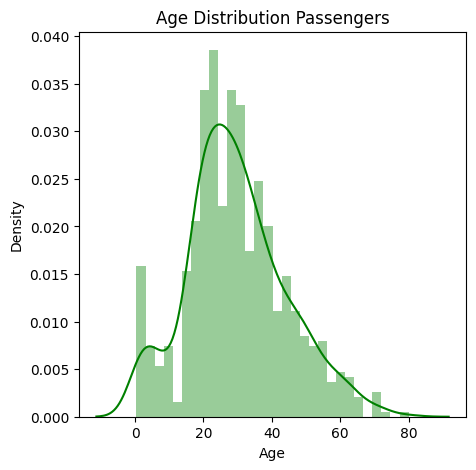

In [27]:
plot_distribution(train_df, "Age", "Age Distribution Passengers")

/tmp/ipykernel_20/2969891125.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 1],
/tmp/ipykernel_20/2969891125.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset[feature1].loc[train_df["Survived"] == 0],


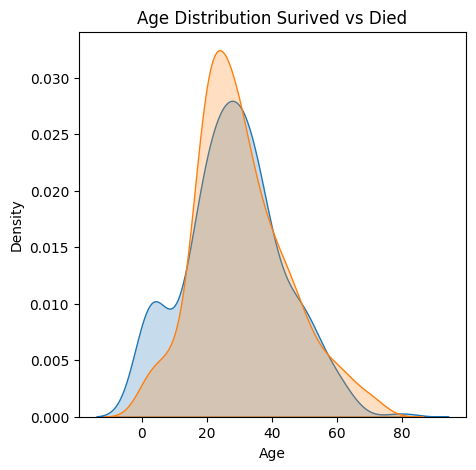

In [28]:
plot_kernel_density_estimate_survivors(train_df, "Age", "Age Distribution Surived vs Died")

The Histogram above shows that age follows a fairly normal distribution.

Also investigating the kernel density estimate does not provide additional information except a raise in survivors at a very young age. However, one idea might be to investigate age and sex together.

In [29]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis.
    ax.grid(True)
    plt.xticks(list(range(0,100,2)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=train_df).set_title(title)

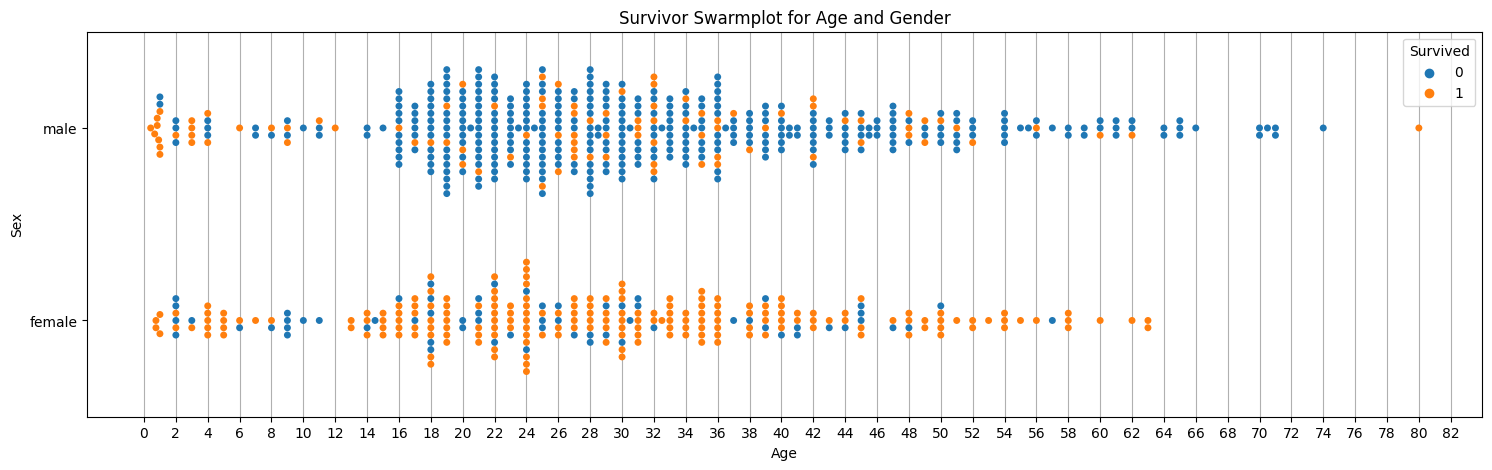

In [30]:
plot_swarm_survivors(train_df, "Sex", "Age", "Survivor Swarmplot for Age and Gender")

In [31]:
def plot_swarm_survivors(dataset, feature1, feature2, title, fize = (155)):
    fig, ax = plt.subplots(figsize=(18,5))
    # Turns off grid on the left Axis.
    ax.grid(True)
    plt.xticks(list(range(0,3,1)))
    sns.swarmplot(y=feature1, x=feature2, hue='Survived',data=train_df).set_title(title)

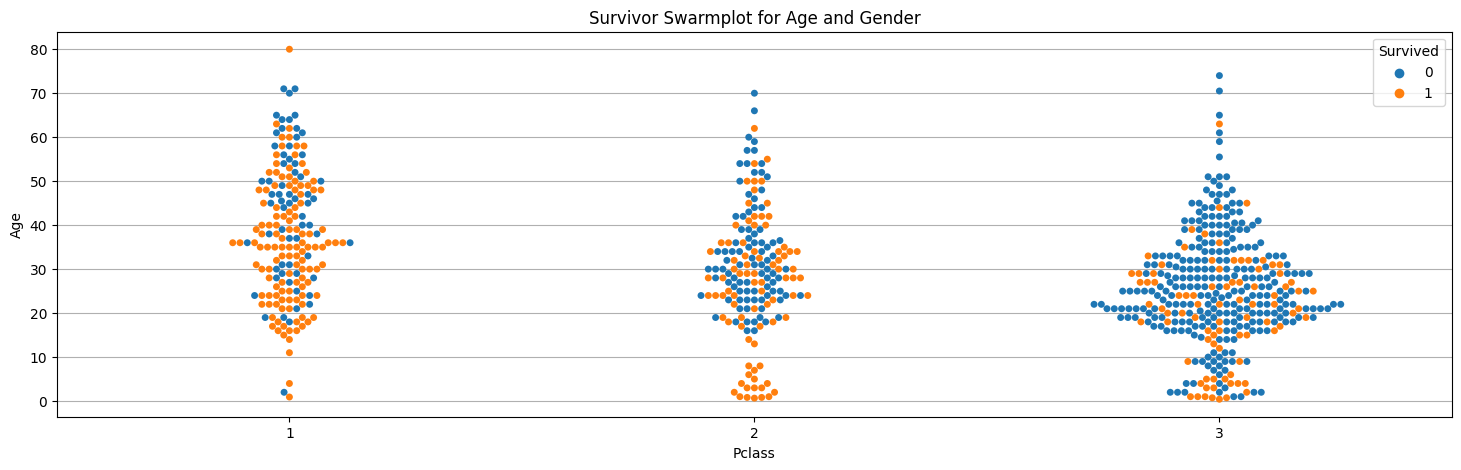

In [32]:
plot_swarm_survivors(train_df, "Age", "Pclass", "Survivor Swarmplot for Age and Gender")

> ***Question 6: Did paying the ticket price influence the chance of survival?***

In [33]:
train_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

/tmp/ipykernel_20/174145078.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df[feature], color='g', bins=bins, ax=ax)


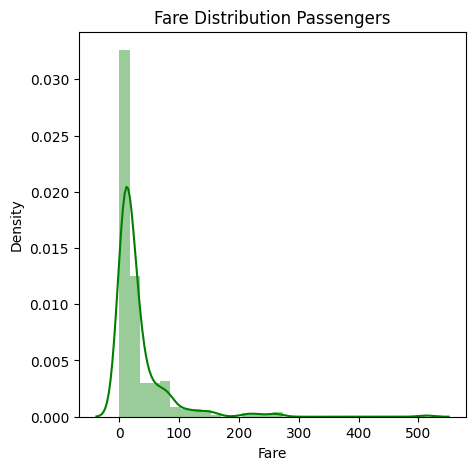

In [34]:
plot_distribution(train_df, "Fare", "Fare Distribution Passengers")

In [35]:
def plot_quartiles(dataset, feature, title, categories):
    fig, axarr = plt.subplots(figsize=(5,5))
    fare_ranges = pd.qcut(dataset[feature], len(categories), labels = categories) #. [0, .25, .5, .75, 1.]
    axarr.set_title(title)
    sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')

/tmp/ipykernel_20/4161477354.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=fare_ranges, y=dataset.Survived, ci=None, ax=axarr).set_ylabel('Survival rate')


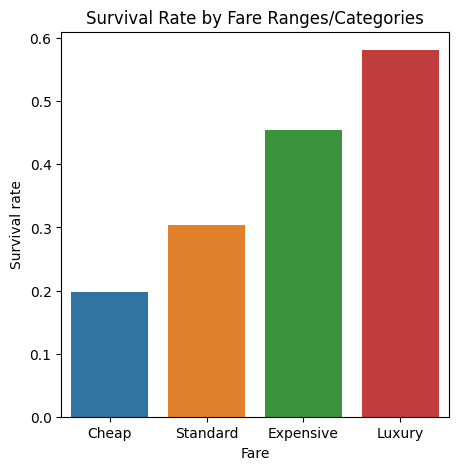

In [36]:
categories = ['Cheap', 'Standard', 'Expensive', 'Luxury']

plot_quartiles(train_df, "Fare", "Survival Rate by Fare Ranges/Categories", categories)

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 54.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


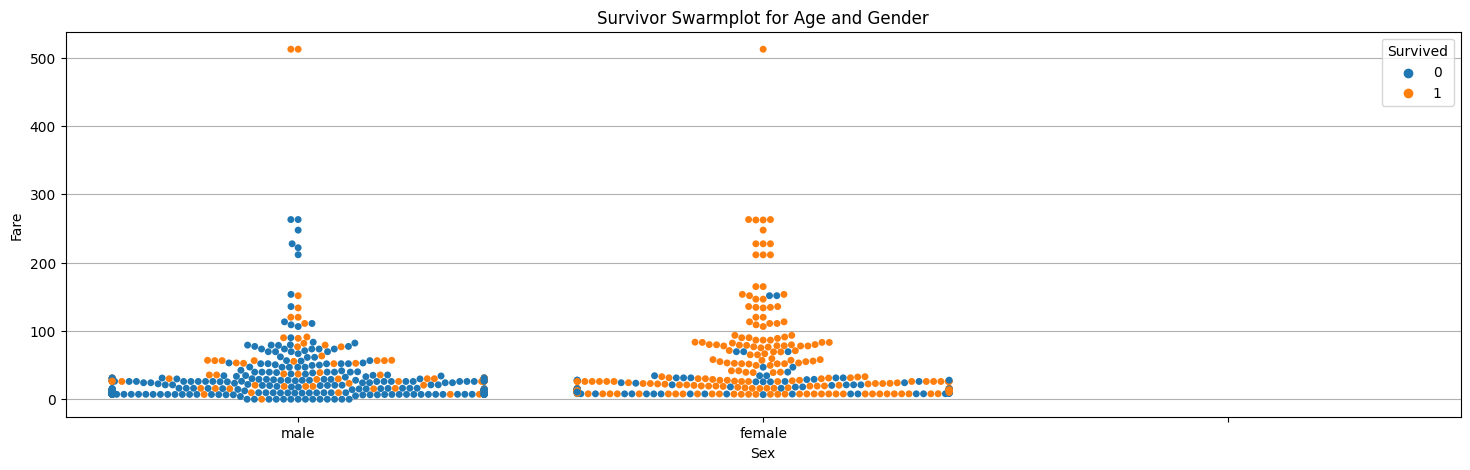

In [37]:
plot_swarm_survivors(train_df, "Fare", "Sex","Survivor Swarmplot for Age and Gender")

In [38]:
train_df.loc[train_df.Fare==0] 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [39]:
len(train_df.loc[train_df.Fare==0])

15

15 Passengers paid no fare. As this is nonsensical I decide to replace 0 values with nan and then later to think about how to impute these values.

In [40]:
# Replace Fare == 0 with nan
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN
test_df.loc[train_df['Fare'] == 0, 'Fare'] = np.NaN

> ***Question 8: Could the place of embarkation influence the chance of survival?***

In [41]:
def show_countplot(dataset, feature, title, fsize = (5,5)):
    fig, ax = plt.subplots(figsize=fsize)
    sns.countplot(x=dataset[feature], ax=ax).set_title(title)
    
def show_compare_countplot(dataset, feature1, feature2, title):
    fig, ax = plt.subplots(figsize=(5,5))
    p = sns.countplot(x = feature1, hue = feature2, data = dataset, ax=ax).set_title(title)   

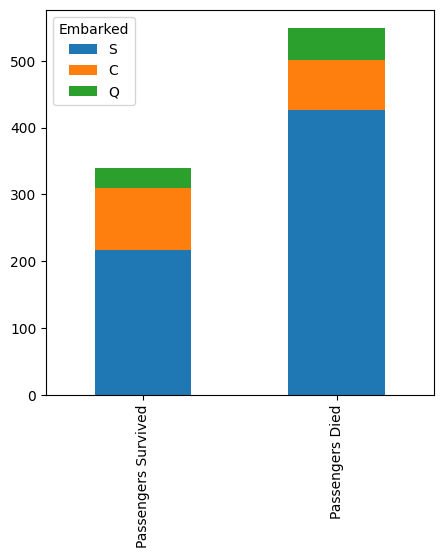

In [42]:
bar_chart_stacked(train_df, 'Embarked') 

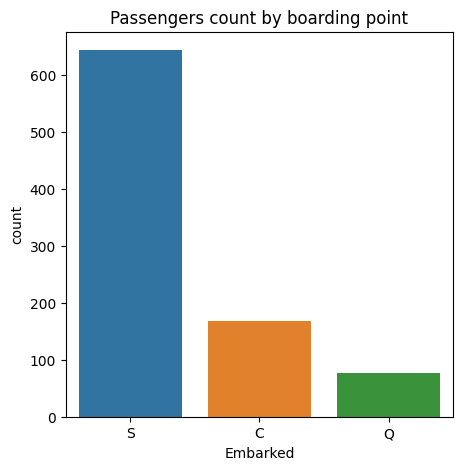

In [43]:
show_countplot(train_df, "Embarked", 'Passengers count by boarding point')

In [44]:
train_df['Embarked'].value_counts().to_frame()

,count
Embarked,
S,644
C,168
Q,77


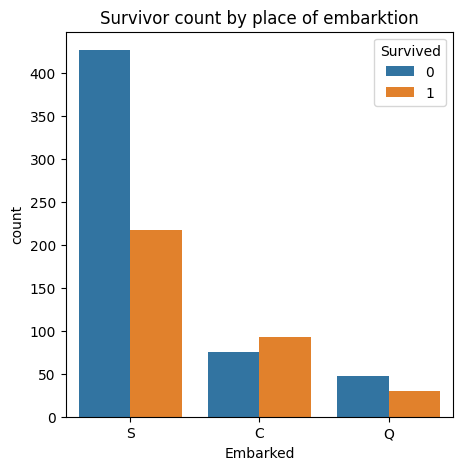

In [45]:
show_compare_countplot(train_df, "Embarked", "Survived", "Survivor count by place of embarktion")

In [46]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [47]:
train_df.groupby(['Embarked']).Survived.mean().to_frame()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


> ***Question 9: Was the high number of survivors that embarked at Cherbourg due to a high number of 1. Class passengers?***

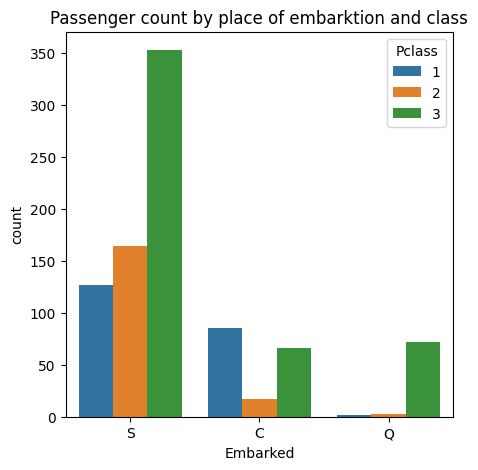

In [48]:
show_compare_countplot(train_df, "Embarked", "Pclass", "Passenger count by place of embarktion and class")

In [49]:
train_df.groupby(['Embarked', 'Pclass']).Survived.sum().to_frame()

Survived
Embarked Pclass          
C        1             59
         2              9
         3             25
Q        1              1
         2              2
         3             27
S        1             74
         2             76
         3             67

> ***Question 10: Is gender distribution responsible for the slightly higher passenger survival rate in Queenstown compared to Southampton?***

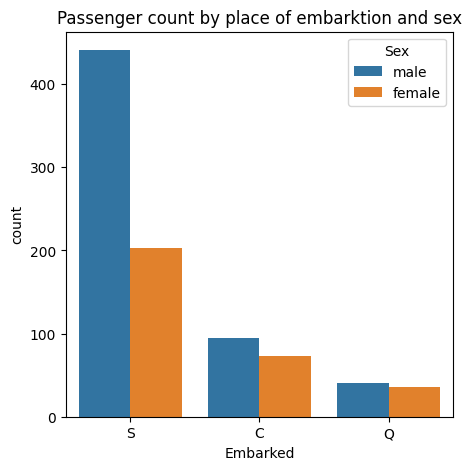

In [50]:
show_compare_countplot(train_df, "Embarked", "Sex", "Passenger count by place of embarktion and sex")

As expected twice as many male passengers embarked from Southam were roughly the same number of male and female passengers embarked from Queenstown. This just shows the importance of the Sex feature.

> ***Question 11: Does the number of children/siblings/spouses or parents on board influence the chance of survival?***

In [51]:
train_df['SibSp'].value_counts().to_frame()   #SibSp is the number of siblings or spouses of a person aboard the Titanic

,count
SibSp,
0,608
1,209
2,28
4,18
3,16
8,7
5,5


/tmp/ipykernel_20/2402733668.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')


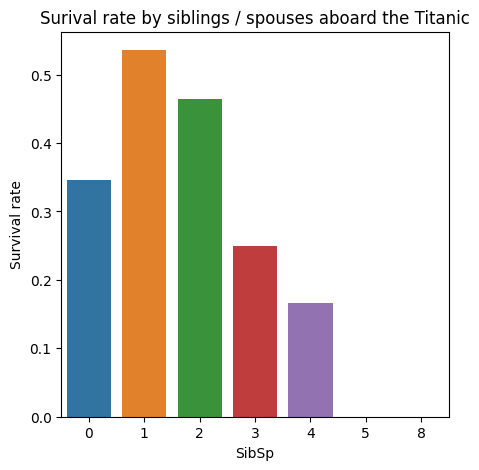

In [52]:
bar_chart_compare(train_df, "SibSp", title = "Surival rate by siblings / spouses aboard the Titanic")

In [53]:
train_df.groupby(['SibSp']).Survived.mean().to_frame()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


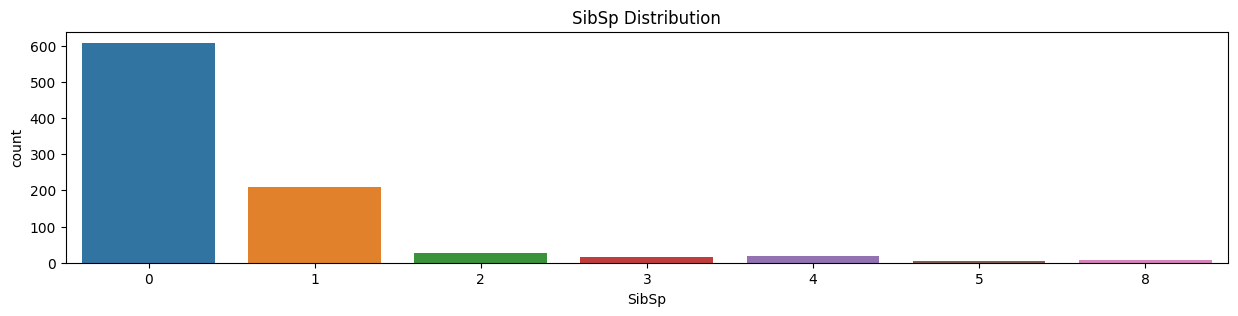

In [54]:
show_countplot(train_df, "SibSp", 'SibSp Distribution', (15,3))

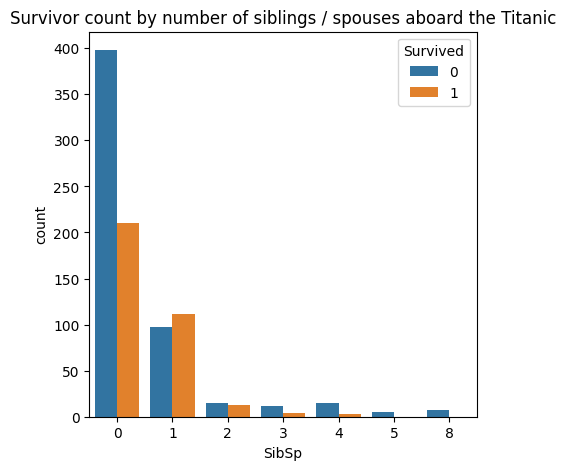

In [55]:
show_compare_countplot(train_df, "SibSp", "Survived", "Survivor count by number of siblings / spouses aboard the Titanic")

The majority traveled alone. It seems that the more Sibling a passenger has the less chance of survival there is.


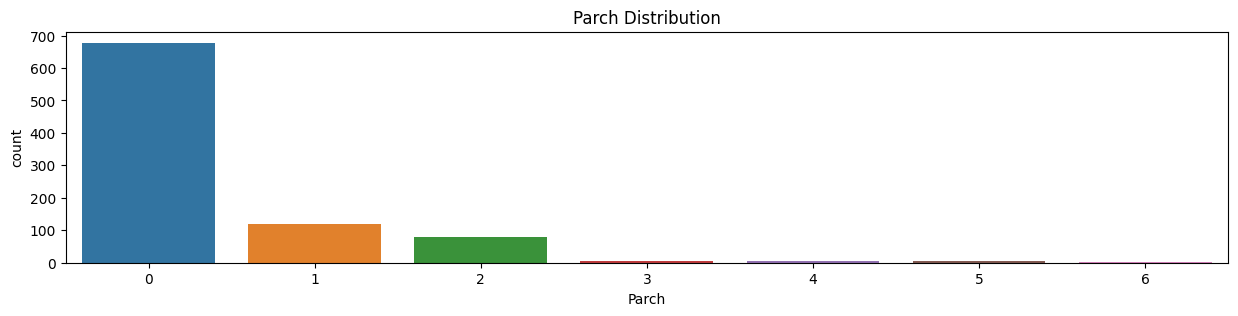

In [56]:
show_countplot(train_df, "Parch", 'Parch Distribution', (15,3)) #Similar to the SibSp column, this feature contains the number of parents or children each passenger was traveling with.

/tmp/ipykernel_20/2402733668.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')


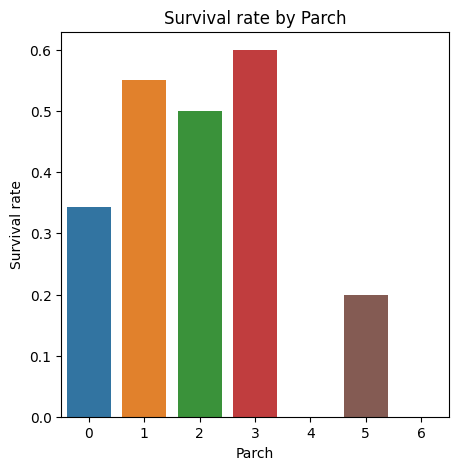

In [57]:
bar_chart_compare(train_df, "Parch", title = "Survival rate by Parch")

In [58]:
train_df.groupby(['Parch']).Survived.mean().to_frame()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


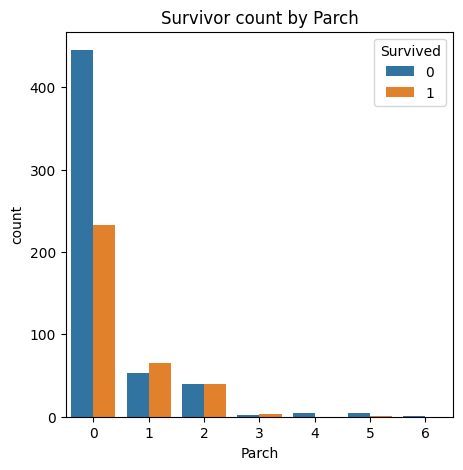

In [59]:
show_compare_countplot(train_df, "Parch", "Survived", "Survivor count by Parch")

Here we draw the same conclusions as for Parch as for SibSp. We can see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

# ***Feature Engineering***

> **Titles****

One feature that we did not consider until now is the name. In theory, a person’s name should have no influence on the probability of survival, but on closer investigation we see that a title is sometimes hidden in the name, which in turn could be quite useful. However, using the different names as categorical variables does not make sense. One idea is to extract the title from the name.

In [60]:
pd.unique(train_df['Name'])

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

To create a new feature we can extract the Titles from the name.


In [61]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [62]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [63]:
train_df['Title'].value_counts().to_frame()

,count
Title,
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2


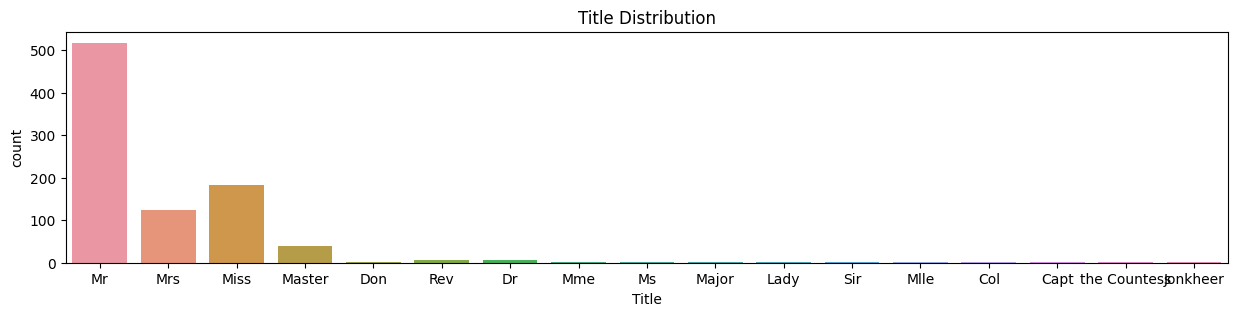

In [64]:
show_countplot(train_df, "Title", 'Title Distribution', (15,3))

As can see the Titles are severely imbalanced. It makes sense to group less frequent Titles together. I will substitute male titles into Mr and female Titles into Mr:

In [65]:
train_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
test_df['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
train_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
test_df['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

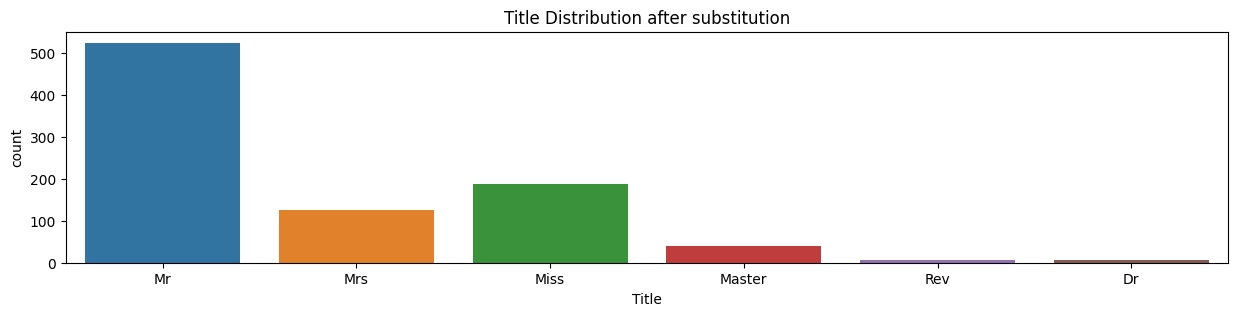

In [66]:
show_countplot(train_df, "Title", 'Title Distribution after substitution', (15,3))

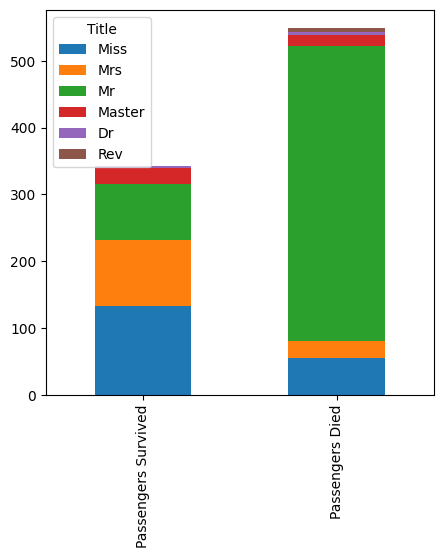

In [67]:
bar_chart_stacked(train_df, 'Title') 

/tmp/ipykernel_20/2402733668.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')


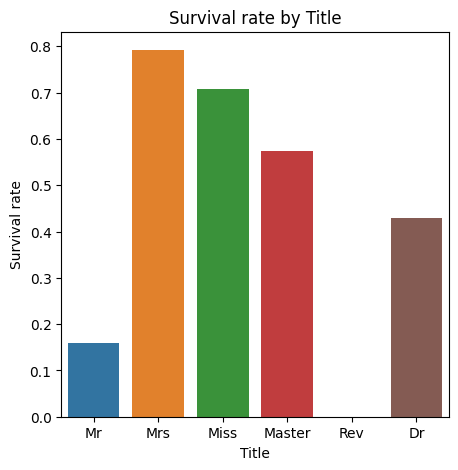

In [68]:
bar_chart_compare(train_df, "Title", title = "Survival rate by Title")

Female titles result in a higher survival rate.
Master and Dr have a surprisingly high survival rate even tough both are male titles.
Being “just” a Mr results in a bad survival rate of approx 15%
All 6 revenants died. Maybe they decided to accept their destiny and wanted to die with dignity.

> ***Feature Cabin and Ticket:***

In [69]:
train_df[['Cabin', 'Ticket']]

,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


As we can see both features are not easy to deal with. Cabin contains a lot of Nans and the ticket seems not to provide any useful information.

We can try different ideas:

Extract two leading letters to create a new feature
Extract number of letter in ticket to create a new features
Extract number of cabins used
Extract Cabin letter

In [70]:
# Extract Leading Letter:
train_df['Ticket_2letter'] = train_df.Ticket.apply(lambda x: x[:2])
test_df['Ticket_2letter'] = test_df.Ticket.apply(lambda x: x[:2])

In [71]:
# Extract Ticket Lenght:
train_df['Ticket_len'] = train_df.Ticket.apply(lambda x: len(x))
test_df['Ticket_len'] = test_df.Ticket.apply(lambda x: len(x))

In [72]:
# Extract Number of Cabins:
train_df['Cabin_num'] = train_df.Ticket.apply(lambda x: len(x.split()))
test_df['Cabin_num'] = test_df.Ticket.apply(lambda x: len(x.split()))

In [73]:
# Extract Leading Letter:
train_df['Cabin_1letter'] = train_df.Ticket.apply(lambda x: x[:1])
test_df['Cabin_1letter'] = test_df.Ticket.apply(lambda x: x[:1])

In [74]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Ticket_2letter,Ticket_len,Cabin_num,Cabin_1letter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,A/,9,2,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,PC,8,2,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,ST,16,2,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,11,6,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,37,6,1,3


In [75]:
len(train_df['Ticket'].value_counts().to_frame())

681

In [76]:
len(train_df["Ticket_2letter"].value_counts().to_frame())

56

In [77]:
len(train_df["Ticket_len"].value_counts().to_frame())

15

In [78]:
len(train_df['Cabin'].value_counts().to_frame())

147

In [79]:
len(train_df['Cabin_num'].value_counts().to_frame())

3

In [80]:
train_df['Cabin_num'].value_counts().to_frame()

,count
Cabin_num,
1,665
2,213
3,13


In [81]:
len(train_df['Cabin_1letter'].value_counts().to_frame())

16

> ***Feature Family Size***

In [82]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch'] + 1

/tmp/ipykernel_20/2402733668.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')


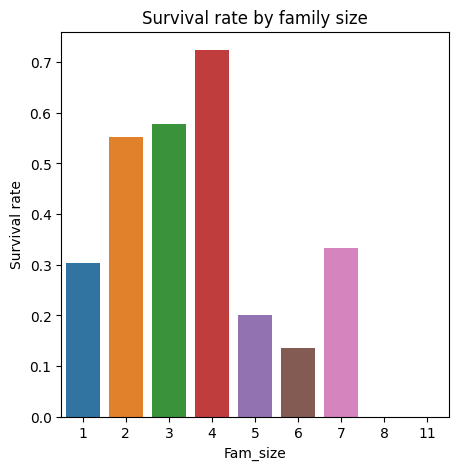

In [83]:
bar_chart_compare(train_df, "Fam_size", title = "Survival rate by family size")

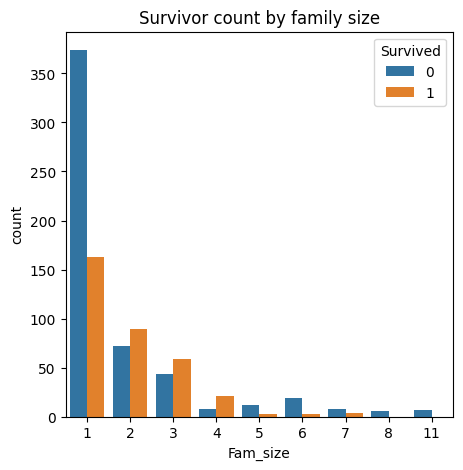

In [84]:
show_compare_countplot(train_df, "Fam_size", "Survived", "Survivor count by family size")

> ***Feature Family Type***

In [85]:
# Creation of four groups
train_df['Fam_type'] = pd.cut(train_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_df['Fam_type'] = pd.cut(test_df.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

/tmp/ipykernel_20/2402733668.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(x=feature1, y='Survived', hue=feature2, ci=None, data=dataset).set_ylabel('Survival rate')


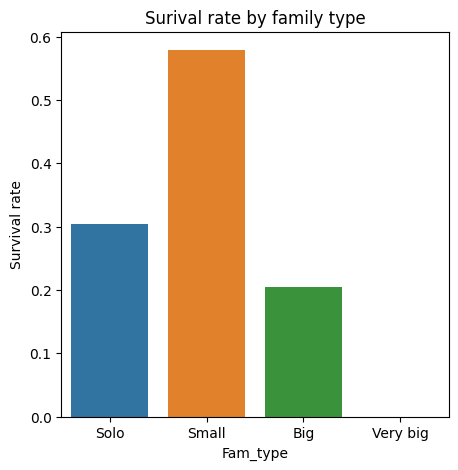

In [86]:
bar_chart_compare(train_df, "Fam_type", title = "Surival rate by family type")

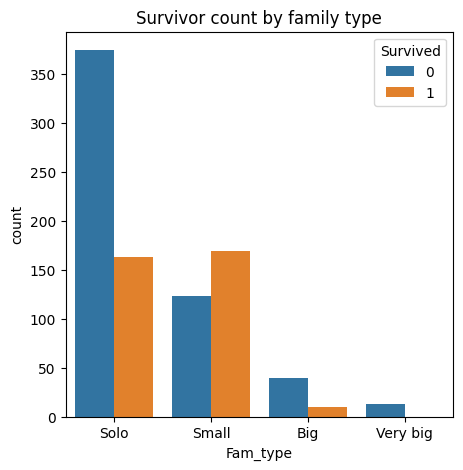

In [87]:
show_compare_countplot(train_df, "Fam_type", "Survived", "Survivor count by family type")

# > ***Training a classifier***

In [88]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter', 'Cabin_num', 'Cabin_1letter']
X = train_df[features]
X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter,Cabin_num,Cabin_1letter
0,3,7.2500,Mr,S,Small,9,A/,2,A
1,1,71.2833,Mrs,C,Small,8,PC,2,P
2,3,7.9250,Miss,S,Solo,16,ST,2,S
3,1,53.1000,Mrs,S,Small,6,11,1,1
4,3,8.0500,Mr,S,Solo,6,37,1,3


In [89]:
from xgboost import XGBRFClassifier
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_2letter', 'Cabin_num', 'Cabin_1letter']

# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')

# Inputing missing values with most frequent one for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Training
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.829


In [90]:
X_test = test_df[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_2letter,Cabin_num,Cabin_1letter
0,3,7.8292,Mr,Q,Solo,6,33,1,3
1,3,7.0000,Mrs,S,Small,6,36,1,3
2,2,9.6875,Mr,Q,Solo,6,24,1,2
3,3,8.6625,Mr,S,Solo,6,31,1,3
4,3,12.2875,Mrs,S,Small,7,31,1,3


In [91]:
predictions = titanic_pipeline.predict(X_test)

In [92]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
